In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019_train.csv')
modeldf2021 = pd.read_csv('mydata/MMSA2021_train.csv')

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140514 entries, 0 to 140513
Data columns (total 180 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    Unnamed: 0  140514 non-null  int64  
 1    DISPCODE    140514 non-null  int64  
 2    STATERE1    47593 non-null   float64
 3    CELPHONE    47593 non-null   float64
 4    LADULT1     47593 non-null   float64
 5    COLGSEX     11 non-null      float64
 6    LANDSEX     20189 non-null   float64
 7    RESPSLCT    24008 non-null   float64
 8    SAFETIME    92921 non-null   float64
 9    CADULT1     92921 non-null   float64
 10   CELLSEX     92917 non-null   float64
 11   HHADULT     92918 non-null   float64
 12   SEXVAR      140514 non-null  int64  
 13   GENHLTH     140501 non-null  float64
 14   PHYSHLTH    140503 non-null  float64
 15   MENTHLTH    140508 non-null  float64
 16   POORHLTH    77558 non-null   float64
 17   HLTHPLN1    140510 non-null  float64
 18   PERSDOC2    140511 non

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151861 entries, 0 to 151860
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  151861 non-null  float64
 1    STATERE1  37094 non-null   float64
 2    CELPHON1  37094 non-null   float64
 3    LADULT1   37094 non-null   float64
 4    COLGSEX   13 non-null      float64
 5    LANDSEX   15568 non-null   float64
 6    RESPSLCT  20603 non-null   float64
 7    SAFETIME  114767 non-null  float64
 8    CADULT1   114767 non-null  float64
 9    CELLSEX   114766 non-null  float64
 10   HHADULT   114766 non-null  float64
 11   SEXVAR    151861 non-null  float64
 12   GENHLTH   151860 non-null  float64
 13   PHYSHLTH  151859 non-null  float64
 14   MENTHLTH  151861 non-null  float64
 15   POORHLTH  81991 non-null   float64
 16   PRIMINSR  151860 non-null  float64
 17   PERSDOC3  151861 non-null  float64
 18   MEDCOST1  151860 non-null  float64
 19   CHECKUP1  151861 non-

In [10]:
#Fill missing values of extra columns with current categorical values to keep ratio randomnly 

In [11]:
#Handle missing data 

### Merging 2019 and 2021 BRFSS Dataframes Using Columns of Interest

In [12]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [13]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [14]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [15]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [16]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [17]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# Concatenate DataFrames based on common columns
brfss_df = pd.concat([modeldf2019[common_columns], modeldf2021[common_columns]],ignore_index=True )


In [18]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')


In [19]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292375 entries, 0 to 292374
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  292375 non-null  float64 
 1    STATERE1  84687 non-null   category
 2    LADULT1   84687 non-null   float64 
 3    COLGSEX   24 non-null      category
 4    LANDSEX   35757 non-null   float64 
 5    RESPSLCT  44611 non-null   float64 
 6    SAFETIME  207688 non-null  category
 7    CADULT1   207688 non-null  category
 8    CELLSEX   207683 non-null  float64 
 9    HHADULT   207684 non-null  float64 
 10   SEXVAR    292375 non-null  float64 
 11   GENHLTH   292361 non-null  category
 12   PHYSHLTH  292362 non-null  float64 
 13   MENTHLTH  292369 non-null  float64 
 14   POORHLTH  159549 non-null  float64 
 15   PRIMINSR  292370 non-null  category
 16   MEDCOST1  292371 non-null  category
 17   CHECKUP1  292370 non-null  category
 18   BPMEDS    110772 non-null  category
 19   

In [20]:
#Lets make a copy of the merged dataframe
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [21]:
#list(processed_features_df['STATE'].unique())

### Generate EDA Report with Original Dataset

In [22]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

#profile = ProfileReport(modeldf2021)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Data Cleaning Handle Missing data

In [23]:
pd.reset_option('display.max_rows',None)

In [24]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   292351  0.999918
NUMPHON3  269608  0.922131
CAGEG     257854  0.881929
LANDSEX   256618  0.877702
DIABAGE3  255624  0.874302
ASTHNOW   250739  0.857594
RESPSLCT  247764  0.847419
PREGNANT  236303  0.808219
NUMHHOL3  208063  0.711631
STATERE1  207688  0.710348
LADULT1   207688  0.710348
ARTHDIS2  202351  0.692094
LMTJOIN3  202349  0.692087
ARTHEDU   202348  0.692084
JOINPAI2  202348  0.692084
ARTHEXER  202347  0.692080
HIVTSTD3  198554  0.679107
_FLSHOT7  189818  0.649228
_PNEUMO3  189818  0.649228
SMOKDAY2  184042  0.629472
BPMEDS    181603  0.621130
FLSHTMY3  152870  0.522856
MAXDRNKS  146416  0.500782
DRNK3GE5  146119  0.499766
AVEDRNK3  145632  0.498100
POORHLTH  132826  0.454300
CELLSEX    84692  0.289669
HHADULT    84691  0.289666
SAFETIME   84687  0.289652
CADULT1    84687  0.289652
_VEGESU1   40157  0.137348
_RFCHOL3   36044  0.123280
_FRUTSU1   34055  0.116477
VEGEDA2_   33123  0.113289
POTADA1_   32643  0.111648
_BMI5CAT   30513  0.104363
_

In [25]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292375 entries, 0 to 292374
Data columns (total 105 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    CADULT1   207688 non-null  category
 1    HHADULT   207684 non-null  float64 
 2    SEXVAR    292375 non-null  float64 
 3    GENHLTH   292361 non-null  category
 4    PHYSHLTH  292362 non-null  float64 
 5    MENTHLTH  292369 non-null  float64 
 6    PRIMINSR  292370 non-null  category
 7    MEDCOST1  292371 non-null  category
 8    CHECKUP1  292370 non-null  category
 9    CVDINFR4  292371 non-null  category
 10   CVDCRHD4  292371 non-null  category
 11   CVDSTRK3  292370 non-null  category
 12   ASTHMA3   292371 non-null  category
 13   CHCSCNCR  292371 non-null  category
 14   CHCOCNCR  292371 non-null  category
 15   ADDEPEV3  292370 non-null  category
 16   CHCKDNY2  292371 non-null  category
 17   DIABETE4  292371 non-null  category
 18   MARITAL   292353 non-null  category
 19   

In [26]:
#Drop redundant Columns and irreleveant columns
processed_features_df.drop(columns=['_BMI5','_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH','HHADULT'],inplace=True)

In [27]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292375 entries, 0 to 292374
Data columns (total 79 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   PHYSHLTH  292362 non-null  float64 
 1   MENTHLTH  292369 non-null  float64 
 2   MEDCOST1  292371 non-null  category
 3   CHECKUP1  292370 non-null  category
 4   CVDSTRK3  292370 non-null  category
 5   CHCSCNCR  292371 non-null  category
 6   CHCOCNCR  292371 non-null  category
 7   ADDEPEV3  292370 non-null  category
 8   CHCKDNY2  292371 non-null  category
 9   DIABETE4  292371 non-null  category
 10  MARITAL   292353 non-null  category
 11  RENTHOM1  292361 non-null  category
 12  VETERAN3  291250 non-null  category
 13  EMPLOY1   289981 non-null  category
 14  HEIGHT3   284006 non-null  float64 
 15  DEAF      282819 non-null  category
 16  BLIND     282065 non-null  category
 17  DECIDE    281393 non-null  category
 18  DIFFWALK  280673 non-null  category
 19  DIFFDRES  280172 non-nu

In [28]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

<Axes: >

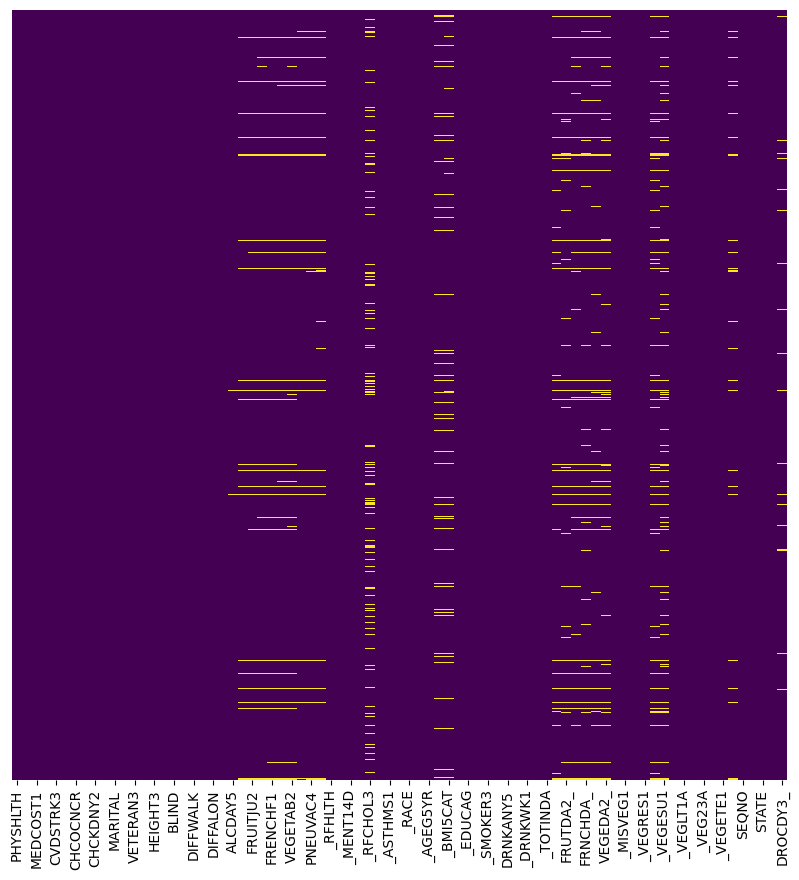

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [ ]:
#Replace missing fruit and vegetable values with the median value for each race & Age category

In [ ]:
#replace BMI and Weight missing data with the median value for each race & Age category

## ANSWERING THE RESEARCH QUESTIONS 

How do dietary habits and nutrition shape an individual's health outcome?
- we know that studies have shown that high fiber intake is associated with lower mortality.
as seen in this comparative study https://pubmed.ncbi.nlm.nih.gov/22648726/. 
- we would like to see how a high vegetable/fruit diet may be associated with a person percieved health. 
- the darker the vegetables the higher the fibre content